<a href="https://colab.research.google.com/github/tomgoter/w207_finalproject/blob/master/gpu_fkd_cnn_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Notebook for Google Colab
## Facial Keypoint Detection
### W207 Final Project - Summer 2019
#### T. P. Goter

This notebook is used to run various convolutional neural networks in Google's Colab environment. This is useful as GPUs are available for free use. These GPUs have been shown to increase runtimes for the networks below by 10-20x. The use of Colab has really enable a thorough evaluation of the neural network hyperparameters and resulted in a better model in the end.

#### Problem Abstract

The goal of our models are to detect facial keypoint locations on input images that are 96 by 96 pixels. In order to do this detection, the modelers choose to evaluate various Convolutional Neural Networks (CNNs) with various architectures, input transformation and hyperparameter settings. These explorations and evaluations result in a final model that is used to evaluate a fixed set of test data that has not been trained on or investigated whatsoever. Through this process the modelers develop a deeper understanding of machine learning (ML), ML applications, deep learning, data preprocessing, hyperparamter tuning and model optimization.

#### Data Source
The original training and test data is provided from Kaggle, as this was a competition in 2016. This data is explored in a separate Jupyter Notebook (DataExploration) which can be found in this [GitHub repository](https://github.com/tomgoter/w207_finalproject). Through this data exploration it was determined that many of the provided images only have labels for some of the keypoints. This means there is much data that is not useful for training. This data could be labeled manually, but that would be excessively time consuming and prone to error. Additionally, not all of the images even have all of the keypoints. It was determined that initial models would only use the training examples which have labels for all 15 facial keypoints. Unfortunately this reduced the size of the data set from >7000 to ~2100. Additional discussion of the data cleaning is included in the previously linked to Jupyter Notebook. This notebook was used to clean and pickle the data (kept in a Pandas dataframe object). This pkl file was then copied to the modeler's Google Drive account to enable easy reading with Colaboratory. This file was too large to keep in GitHub.

#### Scoring Metric
Model quality is determined through the Root Mean Squared Error (RMSE) between predictions and actuals. The  equation for this calculation is given below where the sum is over every prediction (i.e., test examples multiplied by keypoints per example.) This scoring metric will also be used as the loss function (actually just he mean squared error) for the neural network training.

$$RMSE = \sqrt{\frac{1}{n}\cdot\sum\limits_{i=1}^{n}(y-\hat{y})^2}$$

#### Baseline Models
The modeler chose to generate three baseline models from which to gage progress for more advanced models. The first of these baseline models was rudimentary. For any new test image, the mean x and y location for each keypoint was used as the keypoint location prediction. In this case the mean keypoint location was able to be determined through an average over all training data (minus those reserved as development data - ~15%) simply by ignoring the NaNs in the dataset. The resultant RMSE from this simple prediction method was 3.16. Thus, a baseline was established with plenty of room for improvement. For reference, the Public Leaderboard for the [Kaggle Competition](https://www.kaggle.com/c/facial-keypoints-detection/leaderboard) had a high score (or low in terms of RMSE) of 1.53 at the time the competition was completed.

In addition to this simplistic model, the modelers also constructed a k-nearest regressor and an r-nearest regressor model with tuned hyperparameters to determine how much better than the baseline model one could get with a simple, but slightly more advanced model than the baseline. The k-nearest regressor model was implemented, and a k-value of *five* was determined to be optimal based on testing on ~15% of the data reserved as a development set. This model merely identifies the five closest images in the training set to the target image. Image proximity is determined through the euclidean distance in pixel values for all 9,216 pixels. The keypoint locations of the target image are then estimated to be the average of the k (five in our case) nearest images. Using this model, the validation set RMSE was determined to be 2.49. Thus, a substantial improvement over the baseline model was achieved with relative ease. The r-nearest regressor model follows the same basic concept as the k-nearest regressor model, but instead of predetermining the number of images from which to average keypoint locations, instead a radial "distance" is specified. The target image keypoints are then predicted to be the average of all images found within the pre-specified distance. For the model in question, r was determined to be optimized at an approximate distance of 12. This resulted in a RMSE on the validation set of ~2.68 which is worse than the k-nearest regressor model. Due to this depreciation in accuracy and given the additional training time of this model, it was determined that a reasonable baseline+ model was the k-nearest regressor model.

#### Single Layer Neural Nets
On the modeling path toward the CNNs, the modelers made a pit stop at the single layer neural net. This was done to get more familiarity with different training options and simply building neural nets in tensor flow (with Keras as abstraction) and optimizing neural nets. Several sensitivities to the number of hidden units, optimizer and activation function were evaluated. All of these sensitivities were interesting, but in general the modelers found that the single layer models were underperforming and overfitting. Investigating the differences in gradient descent optimizers was as interesting outcome of this pit stop, and through these evaluations further emphasis was placed mostly on the stochastic gradient descent (SGD) optimizer with Nesterov (look-ahead) momentum and the ADAM optimizer which adapts training rates for each parameter in the model.

#### Double Layer Nerual Nets
If single layer neural nets was a pit stop, the modelers foray into double layer perceptrons was more of a rolling-stop past a stop sign. Fruitful results were not obtained; overfitting and underperforming continued. The modelers determined perhaps there is a reason people are using CNNs for image detection after all. Thus, emphasis was next placed on building deeper neural nets. This is discussed in the next section.

#### Convolutional Neural Nets

Convolutional neural nets typically make use of a deep network architecture with limited breadth. The basic principal for image processing is to start with your image pixel values, and then convolve the image through a smaller kernel matrix such as shown in the image below. Each kernel matrix cell is initialized with a random weight, and these weights are learned by training the model. This kernel slides over the input feature matrix as shown by the image below. As this process continues the features are transformed. This transformation continues in layers. In between convolution layers the feature set size is typically decreased through a pooling layer in which another kernel matrix is used (many times 2x2) to identify either the average feature value (average pooling) or the maximum feature (max pooling) from this small grid. This process results in a greatly reduced number of dimensions (e.g., if using a 2x2 pooling layer, the dimensions are halved). This process of convolving and reducing dimensions basically allows the neural net to slowly transform the starting feature space into higher level items it can use to classify (or in this case regress). After several convolutions and poolings, the remaining dimensions are flattened and passed to one or two fully connected layers. These output layers are then used to perform the regression by narrowing down to 30 outputs. Note that for classification it is typically to see a softmax (version of a sigmoid function) as the output activation function, but for this regression problem a floating point output is desired. As such, a linear (identity) activation function is used for the final output layer.


![alt text](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif)

The basic principles and conventions behind building a CNN can be summarized by the following bullets.



*   Small filters are typically used first (i.e., 2x2 to 5x5 or thereabouts) to gather the local information from the base image.
*   As we step deeper into the network, the filter width can be expanded. The theory behind this is that as we go deeper into the network we begin to explore more global features as we have already captured the local features.
* In terms of filter depth, start with a lowish number (it seems like 8 to 32 is fairly common), and increase as depth is added
* Layers are added until overfitting starts to occur. Overfitting can then be addressed through various methods. One can implement dropout rates or regularization fairly easily at different levels throughout the network to help address this.
* There are many existing architectures from which to start from, as discussed below.

**AlexNet Inspired Models**

The modelers chose to begin with a simple AlexNet-inspired architecture which [has it roots in the early 1980s](https://www.analyticsvidhya.com/blog/2017/08/10-advanced-deep-learning-architectures-data-scientists/).  This architecture, in the grand scheme of different CNN architectures, is quite simple and easy to understand. It was the natural starting point for this regression analysis and is quite quick to train on the Colaboratory GPUs. This architecture is outlined in the figure below. The basic principle of this architecture that was followed for this analysis is to simply alternate convolution and pooling layers. For the models developed herein, three convolution-pooling layers were used. During each convolution layer, kernel depth is increased. This basically means that several independent kernels, each with unique weights to learn, are used during the training. Through this process, as shown by the image below, the feature space is reduced in the original dimensions (let's call them height and width) but increased in the depth dimension. The original feature space is replaced by these learned transformations. At each layer the user can specify kernel size, filter depth, dropout rate, and a variety of other parameters that all help in the model tuning process. During the model building discussed herein sensitivities were run to many of these hyperparameters, and in the end an optimized AlexNet model was developed. This model scored an RMSE of ~1.25 on the validation data. Unfortunately when scored against the actual Kaggle test data, it only achieved a 2.87 RMSE which would be about 53rd on the leaderboard. This result led to development and testing of additional model architectures as discussed below.

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/08/08131757/temp6.png)

**VGG Net Inspired Models**

As an alternative to starting with something that resembles an AlexNet architecture, the modelers also decided to construct a model inspired by the [VGG Net](https://www.analyticsvidhya.com/blog/2017/08/10-advanced-deep-learning-architectures-data-scientists/). As compared to the AlexNet, the VGG Net is much deeper. Its basic idea is to layer many convolutions prior to pooling and applying dimensionality reduction. This results in more parameters to train and longer model training times. A basic representation of a VGG Net is shown in the image below. Overall the results of the VGG Nets were comparable to the AlexNet-inspired models, but the additional runtime (~factor of 8) from the VGG-inspired nets was basically just wasted GPU resources. This path was investigated for a few different sensitivities, but after non-inspiring results, it was abandoned in favor of additional AlexNet studies. For reference, the modelers' best VGG-inspired net resulted in an RMSE of 2.92 on the Kaggle test data.

![alt text](https://tech.showmax.com/2017/10/convnet-architectures/image_0-8fa3b810.png)

**Specialist Models**

The AlexNet results both in terms of efficiency and accuracy led the modelers to continue building more specialized model. Instead of building one model that tries to accurately locate the x- and y-coordinates of all 15 facial keypoints, the decision was made to instead build 15 models. There are two significant benefits and one significant deleterious effect of this decision.  First, the good parts:

1. Specialized models will allow the modelers to use all the training data. As previously noted, there were only about 2100 examples with all locations labeled. However some keypoints had > 7000 labels. Thus, the dataset for the combined models was much smaller than it really could be if all data were used. There should be a benefit to using all of the training data for the creation of these specialized models.
2. Specialized models were expected to be more accurate, even without additional training data, because the point of the entire network is only to identify a single keypoint. Thus, all of the training and learning done by the model is hyper-focused on the individual output. This also allows the modeler to tune hyperparameters for different keypoints, as necessary.

But of course the downside must also be discussed.

The specialized models will increase our model training time by at least a factor of 15. In addition to this, if the modelers are to tune each model, the amount of hands-on time is greatly increased. This is not an insignificant challenge to overcome. The modelers tried to balance this downside by first running all 15 models, starting with the combined model weights and hyperparameters. This method by itself resulted in very significant improvements in generalization of the model. The predictions from this model were evaluated against the Kaggle test set and determined to have an RMSE of 2.18 (public kaggle score) - an improvement of ~0.7 from the combined AlexNet model!

The accuracies of the specialized models were then inspected and ranked and focused effort was placed on improving the worst performing models, as shown below. This ranking allowed the modelers to determine which keypoints to prioritize. From the list below, it appears that significant benefit could come just from improving the predictions of the first two keypoints (i.e., mouth_center_bottom_lip and nose_tip).

1.   mouth_center_bottom_lip 2.90
2.   nose_tip  2.65
3.   left_eye_center 2.04
4.   right_eye_center           1.94
5.   left_eyebrow_outer_end     1.86
6.   right_eyebrow_outer_end    1.72
7.   right_eyebrow_inner_end    1.64
8.   mouth_right_corner         1.54
9. left_eyebrow_inner_end     1.51
10. mouth_center_top_lip       1.48
11. mouth_left_corner          1.42
12. right_eye_outer_corner     1.40
13. left_eye_outer_corner      1.30
14. right_eye_inner_corner     1.10
15. left_eye_inner_corner      1.05

**Improved Specialist Models**

The process of improving just the two worst specialist models was quite time consuming. The team found that increasing the number of layers and the starting filter depth led to improved results, but in order to reduce overfitting this needed to be coupled with increased dropout rate. The original specialist models implemented a dropout strategy in which the first layer had no dropout, but after every additional layer an additional 10% dropout was added. This strategy was useful in reducing overfitting for the AlexNet which was training to predict all 15 keypoints. For our improved specialist models, our dropout rate strategy was modified to start at 20% and ramping to 65% after the fourth layer. Additionally, in order to reduce the overall number of parameters to train, the improved specialist models for the nose_tip and mouth_center_bottom_lip made use of only 200 hidden units in the fully connected layers. After optimization, the final specialized models for the nose_tip and mouth_center_bottom_lip had a little over a million parameters in each model, relative to ~3.2 in the original specialist models.

Using this method we were able to reduce our validation RMSE scores for our worst two keypoints (i.e., mouth_center_bottom_lip and nose_tip).  The resulting validation scores for our improved models were:

1.   mouth_center_bottom_lip 2.90  -->  **2.54**
2.   nose_tip  2.65 --> **2.41**

With improving only our two worst performing specialist models, we scored against our test set and showed public/private Kaggle scores of 2.09/1.71. In fact the private score was good enough to knock us into 9th place on the private leaderboard.  Not bad!

#### Conclusions

Our final project consisted of learning how to build, train and improve a convolutional neural network in order to learn to predict the location of facial keypoints such as the tips of noses and the centers of eyes. We compared CNN performance against two baseline models (mean model and KNN) and showed vastly superior performance. This superior performance did not come for free, and did require significant CPU/GPU training time and user time to determine how to optimize hyperparameters such as filter depth, dropout rate, and dense layer size. This project was very effective and providing our team with a empirical framework from which to build on our fundamental understanding of simple neural networks and extend that into the deep learning architecture space.

In [1]:
# Import tensorflow and check the version - we will be using version 1.14
import tensorflow as tf
print(tf.__version__)

# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline
import os
import pprint
from google.colab import drive

1.14.0


In [0]:
# Clean up your session
tf.keras.backend.clear_session()


## Link to Google Drive Account to get access to our dataset

Colaboratory allows users to link directly to their Google Drive. So that makes it relatively easy to access our training data and save models as we run our studies. We separately manage our data between GitHub and Google Drive to stay synchronized and maintain version control.

In [3]:
# Mounting the drive is straightforward but required authentication each time 
# we reset the session
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/FacialKeypointDetection/'
! ls /content/drive/My\ Drive/FacialKeypointDetection/OutputData


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
4l_spec_left_eye_center_d0.2_s0.15_sf20_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_left_eye_center_d0.2_s0.2_sf20_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.05_s0.1_sf8_lrf10_fc1200_fc250_kern2334.pkl
4l_spec_mouth_center_bottom_lip_d0.05_s0.1_sf8_lrf10_fc150_fc250_kern2334.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.0_sf4_lrf1_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.0_sf4_lrf20_fc1200_fc2200_kern2345.pkl
4l_sp

## Import our data from our drive
- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb.
- This dataset has the NaNs removed and a few mislabeled images removed as well.
- As such there is only limited training and development data to use.
- The image data has already been normalized to [0,1]

In [0]:
! ls /content/drive/My\ Drive/FacialKeypointDetection/

df_nostache_nonan.pkl	      df_nostache_w_flip.pkl  OutputData
df_nostache_nonan_w_flip.pkl  Models


In [0]:
# Initialize Random Seed for reproducibility
np.random.seed(13)

# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle(drive_path + "df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x.reshape(96,96,1) for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])



## Setup our Optimizer

Based on our previous studies (see cnn_notebook_tpg for details), we will focus efforts with the stochastic gradient descent (SGD - epoch based updates) and the ADAM optimizer (parameter specific gradients with decaying learning rate based on average of past gradients and squared gradients). See the image below for the results of an early optimizer study. The image shows that the Adam and SGD optimizer perform similarly. The adagrad optimizer also converges to about the same accuracy as the other two but appears to take a bit longer to get there. It was also shown to be unstable in terms of epoch training time (note the steep increase in cumulative training time for this optimizer in the third subplot). For these reasons (and to whittle down the number of parameters we continue to evaluate) we did not further consider the adagrad optimizer.

![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/optimizer.png?raw=true)

In [0]:
# Use the adam optimizer with the default learning rate
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Set up an sgd optimizer as well
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)

## Create a Epoch Timing Callback

In addition to using RMSE as a metric to evaluate our models against, we also want to track model training time. If a factor of 10 increase in training time leads to a small accuracy benefit we will tend to gravitate toward the more efficient model.

In [0]:
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## Create a CNN Model

We are going to change the filter strategy from our previous CNN (see cnn_notebook_tpg.ipynb [GitHub Repo (https://github.com/tomgoter/w207_finalproject)) which used the following:

32 filters --> 64 filters --> 128 filters

Let's halve the number of filters and determine the effects on accuracy and run time for our model.

The function below is simple and creates a fixed CNN with three convolute/pool layers and two fully connected layers before the output layer. This model is really just to get our feet wet with building a "deep" neural net using tensor flow and keras. Later we will parameterize our function to enable easy, straightforward sensitivity evaluations. But for this first go around, let's keep it simple.

In [0]:
# Create a function that will automate the CNN model generation
def create_cnn_model():
  '''
  Simple function that retruns a keras cnn model
  Alternate between convolution and pooling
  No dropout or regularization
  Valid padding during convolution
  500 hidden units in fully connected layers
  '''
  
  # Instantiate our model as a Sequential model
  cnn_model = tf.keras.models.Sequential()
  
  # First layer has 96,96,1 dimensions - our image is 96 by 96 pixels and we omit color channels (greyscale)
  cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
  
  # After this layer we will have 94,94,16 - the valid (or no) padding will reduce the size of our input
  # dimensions
  cnn_model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid', activation='relu'))
  
  # After this pooling layer we will have 47,47,16 - pooling with a 2,2 kernel will halve our dimensions
  cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # After this convolution layer we will have 46,46,32
  # Again the convolution layer is not padded so we reduce in dimensionality
  cnn_model.add(tf.keras.layers.Conv2D(32, (2, 2), padding='valid', activation='relu'))
  
  # After this pooling layer we will have 23,23,32 - max pooling with 2x2 kernel
  cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # After this convolution layer we will have 22,22,64
  # Valid padding - reduce dimensionality
  cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
  
  # After this pooling layer we will have 23,23,64
  # Max pooling 2x2 - halve dimension space
  cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  
  # When we flatten we have 33,856 nodes
  cnn_model.add(tf.keras.layers.Flatten())
  
  # Reduce to 500 hidden units
  cnn_model.add(tf.keras.layers.Dense(500))
  cnn_model.add(tf.keras.layers.Activation('relu'))
  
  # Second fully connected layer
  cnn_model.add(tf.keras.layers.Dense(500))
  cnn_model.add(tf.keras.layers.Activation('relu'))
  
  # Output layer is size 30 - equal to the number of keypoint coordinates we are predicting
  cnn_model.add(tf.keras.layers.Dense(30))
  cnn_model.add(tf.keras.layers.Activation('linear'))
  
  print(50*"=")
  print(cnn_model.summary())
  print(50*"=")
  
  return cnn_model
  

##Construct the model on the TPU

Attempts were made to run our models on the TPU, and the following code is required to do so. Although the models were able to run on the TPU, there appeared to be no performance benefit relative to the GPU which was unexpected. However, as we were getting reasonable performance out of the GPU we did not further troubleshoot the TPU application. The cell below was retained in case we did want to do further evaluations on the TPU.

The following information is useful to know when setting up our model for running on a TPU:

**batch_size**
Determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.

**steps_per_epoch**
The number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.

**validation_steps**
similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.

In [0]:
# Grab the hardware address of the TPU and get a list of all of the assigned devices
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:' + devices)

# Access the tpu and create a distribution strategy
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

# Compile the model using the TPU distribution strategy
with strategy.scope():
  model = create_cnn_model()
  model.compile(
      optimizer=adam,
      loss='mean_squared_error',
      metrics=['mean_squared_error'])

W0719 18:13:38.583853 140366703122304 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0

In [0]:
model = create_cnn_model()
model.compile(
      optimizer=adam,
      loss='mean_squared_error',
      metrics=['mean_squared_error'])

W0721 16:38:04.514947 139916523657088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0

## Try out our first CNN Model

The code below is a simple example of how a model is run on a GPU. The output from this model is basically our baseline CNN. Storing the results of the model fitting to the history object allows us to access epoch data such as timing and loss data.

In [0]:
# Fit the basic CNN
history = model.fit(
    train_X.astype(np.float32), train_y.astype(np.float32),
    epochs=200,
    validation_split=0.15)

Train on 1523 samples, validate on 269 samples
Epoch 1/200
1523/1523 [==============================] - 4s 3ms/sample - loss: 2186.5384 - mean_squared_error: 2186.5391 - val_loss: 85.1574 - val_mean_squared_error: 85.1573
Epoch 2/200
1523/1523 [==============================] - 0s 270us/sample - loss: 21.9787 - mean_squared_error: 21.9787 - val_loss: 12.5287 - val_mean_squared_error: 12.5287
Epoch 3/200
1523/1523 [==============================] - 0s 267us/sample - loss: 11.4104 - mean_squared_error: 11.4104 - val_loss: 11.7648 - val_mean_squared_error: 11.7648
Epoch 4/200
1523/1523 [==============================] - 0s 258us/sample - loss: 10.9332 - mean_squared_error: 10.9332 - val_loss: 11.3901 - val_mean_squared_error: 11.3901
Epoch 5/200
1523/1523 [==============================] - 0s 260us/sample - loss: 10.8059 - mean_squared_error: 10.8059 - val_loss: 13.0320 - val_mean_squared_error: 13.0320
Epoch 6/200
1523/1523 [==============================] - 0s 252us/sample - loss: 10.93

## Stride versus Pool Sensitivity

The following code section will look at using a stride of 2 instead of using a pooling layer in order to determine which performs better for our model. Both cases perform the same task of reducing our input matrix size by a factor of 2. Based on some reading, it was indicated that the use of a stride greater than one might be a good alternative to adding a pooling layer.

However the results of our limited study indicated that max pooling actually performed better. From this point on all studies maintained a stride of one. In other words when performing the convolution, our kernel slides one feature or matrix cell at a time.

In [0]:
def create_stride_cnn_model(start_filter, d, step):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), strides=(2,2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), strides=(2,2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), strides=(2,2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [0]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam, 'sgd':sgd}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_stride_df = pd.DataFrame()

# Start filter list
start_filters = [16]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.00), (0.0,0.01), (0.00,0.02)]

for opt_name, opt in opt_list.items():
    for start_filter in start_filters:
        for d in dropouts:
            model = create_stride_cnn_model(start_filter,d[0], d[1])
            model.compile(
                  optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
            history = model.fit(
                X.astype(np.float32), y.astype(np.float32),
                epochs=200,
                validation_split=0.15, callbacks=[time_callback, early_stop])
            times = time_callback.times

            # Convert to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times
            hist['starting_filter'] = start_filter
            hist['layers'] = 3
            hist['pooling'] = 'yes'
            hist['fc_layer'] = 500
            hist['activation'] = 'relu'
            hist['optimizer'] = opt_name
            hist['lrate'] = opt.get_config()['learning_rate']
            hist['dropout_initial'] = d[0]
            hist['dropout_step'] = d[1]
            hist['batch_norm'] = 1
            hist['bias'] = 0
            hist['stride'] = 2

            # Keep concatenating to dataframe
            cnn_stride_df = pd.concat([cnn_stride_df,hist])

            # Re-pickle after every model to retain progress
            cnn_stride_df.to_pickle(drive_path+"OutputData/cnn_stride_df.pkl")

            # Save models.
            filename = "cnn_stride_model_{}_d{}_s{}_sf{}_stride2".format(opt_name, d[0], d[1], start_filter)
            model.save(drive_path+"Models/"+filename+".h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 47, 47, 16)        144       
_________________________________________________________________
batch_normalization_5 (Batch (None, 47, 47, 16)        64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 23, 32)        2048      
_________________________________________________________________
batch_normalization_6 (Batch (None, 23, 23, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)       

## Learning Rate Sensitivity

Several rounds of sensitivity studies were performed outside on the Colaboratory environment on the team's personal computers. Many of these studies can be found in the cnn_notebook_tpg.ipynb file located in the team's [GitHub repository](https://github.com/tomgoter/w207_finalproject).

To summarize what was learned from those studies:

1.   Starting filter depth of 12 to 16 was a better balance to runtime and accuracy than starting with the initial assumption of 32. This is clearly shown below. The starting filter size of 32 is unnecessary for accuracy and runs much more slowly than a reduced starting filter depth.
![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/starting_filter.png?raw=true)
2.   It was also determined (as previously mentioned in this document) that the Adam and SGD optimizers performed the best for these models. 
3.  The use of batch normalization (without a bias term) allows us to increase the learning rate and achieve better accuracies. Batch normalization basically standardizes the feature set after every convolution/pooling layer. The image below shows that the use of batch normalization does lead to faster convergence, but comes at the cost of model runtime. 

![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/batch_norm.png?raw=true)

4. Gradual dropouts starting at 0 and increasing by small amounts appeared to give the best final accuracies (but this is further explored below).

This cell blocks below were used to pick-up where the aforementioned notebook left off. From here on out all models were built and run through the Colaboratory environment to make the progress easier to follow. We start with a learning rate sensitivity, which also explore different dropout rates and starting filter sizes. 

The results of the experiment below seemed to indicate that learning rates between 5x to 10x the default rate of 0.001 seem to perform better than the default rate, and that this is true for both starting filter depths of 12 and 16. See the plot below which was generated with the neural_net_analysis.ipynb notebook located at the GitHub repository (link above)

![image](https://github.com/tomgoter/w207_finalproject/raw/master/Images/LR_Sense_16SF.png "Learning Rate Sensitivity")



In [0]:
def create_bn_cnn_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model that implements
    convolute/pool framework (similar to AlexNet). It makes use of valid padding during the convolution
    layers with rectified linear unit activation functions. Kernels are typically 2x2. Starting filter 
    depth can be varied, but it is assumed the filter depth increases by a factor of two during every 
    convolution (inspired by AlexNet architecture)
    '''
    # Instantiate Sequential Model
    cnn_model = tf.keras.models.Sequential()
    
    # Define Input structure
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    
    # Define convolution layer - takes the start_filter parameter as the filter depth
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', activation='relu', use_bias=False))
    
    # Standardize the convoluted features
    cnn_model.add(layers.BatchNormalization())
    
    # Max Pool - reduce the feature space
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add a form of regularization through dropout - dropout rate is parameterized
    cnn_model.add(tf.keras.layers.Dropout(d))
    
    # Rinse and repeat for two more full layers - increasing filter depth and dropout rate
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    
    # Flatten the feature space and transition to fully connected layers
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    
    # Output layer of 30 keypoint coordinates with linear activation
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [0]:
# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_lr_df = pd.DataFrame()

# Start filter list
start_filters = [12, 16]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.00), (0.0,0.01), (0.00,0.02), (0.00,0.03)]


# Run a parameteric set of studies
for lr_factor in [2, 5, 10]: 
    for start_filter in start_filters:
        for d in dropouts:
            model = create_bn_cnn_model(start_filter, d[0], d[1])
            # Use the adam optimizer with the default learning rate
            adam = optimizers.Adam(lr=0.001*lr_factor, beta_1=0.9, beta_2=0.999)
            model.compile(
                  optimizer=adam,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
            history = model.fit(
                X.astype(np.float32), y.astype(np.float32),
                epochs=200,
                validation_split=0.15, callbacks=[time_callback, early_stop])
            times = time_callback.times

            # Convert model output to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times
            
            # Add model specific metadata to differentiate between models
            hist['starting_filter'] = start_filter
            hist['layers'] = 3
            hist['pooling'] = 'yes'
            hist['fc_layer1'] = 500
            hist['fc_layer2'] = 500
            hist['activation'] = 'relu'
            hist['optimizer'] = 'adam'
            hist['lrate'] = adam.get_config()['learning_rate']
            hist['dropout_initial'] = d[0]
            hist['dropout_step'] = d[1]
            hist['batch_norm'] = 1
            hist['bias'] = 0
            hist['stride'] = 1

            # Keep concatenating to dataframe
            cnn_lr_df = pd.concat([cnn_lr_df,hist])

            # Re-pickle after every model to retain progress
            cnn_lr_df.to_pickle(drive_path+"OutputData/cnn_lr_df.pkl")

            # Save models.
            filename = "cnn_lr_{}_d{}_s{}_sf{}_lrfactor{}".format('adam', d[0], d[1], start_filter, lr_factor)
            model.save(drive_path+"Models/"+filename+".h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_5 (Batch (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 24)       

In [0]:
def create_vgg_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    
    # Input layer is our grayscale image that is 96 pixels by 96 pixels
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    
    # Add our first convolution layers which is two back-to-back conv with 3x3 kernel and same padding
    # Add depth with filters
    # Our output from these convolutions will be (96,96,start_filter)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (48,48,32)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d))
    
    # Add our second convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth - output layer will be (48,48,start_filter*2)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (24,24,start_filter*2)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    
    # Add our third convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (24,24,start_filter*4)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (12,12,start_filter*4)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    
    # Add our fourth and final convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (12,12,start_filter*8)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (6,6,start_filter*8)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and transition to fully connected layers
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [0]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_vgg_lr_df = pd.DataFrame()

# Start filter list
start_filters = [12, 16]

# Flag for using or not using bias term
biases = [False]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.0,0.02)]


for lr_factor in [5, 10]:
  for opt_name, opt in opt_list.items():
      for start_filter in start_filters:
          for bias in biases:
              for d in dropouts:
                  adam = optimizers.Adam(lr=0.001*lr_factor, beta_1=0.9, beta_2=0.999)
                  model = create_vgg_model(start_filter, d[0], d[1], bias)
                  model.compile(
                        optimizer=opt,
                        loss='mean_squared_error',
                        metrics=['mean_squared_error'])
                  history = model.fit(
                      X.astype(np.float32), y.astype(np.float32),
                      epochs=200,
                      validation_split=0.15, callbacks=[time_callback, early_stop])
                  times = time_callback.times

                  # Convert to dataframe
                  hist = pd.DataFrame(history.history)
                  hist['epoch'] = history.epoch
                  hist['RMSE'] = np.sqrt(hist.mean_squared_error)
                  hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
                  hist['times'] = times
                  hist['starting_filter'] = start_filter
                  hist['layers'] = 4
                  hist['pooling'] = 'yes'
                  hist['fc_layer'] = 500
                  hist['activation'] = 'relu'
                  hist['optimizer'] = opt_name
                  hist['lrate'] = opt.get_config()['learning_rate']
                  hist['dropout_initial'] = d[0]
                  hist['dropout_step'] = d[1]
                  hist['batch_norm'] = 1
                  hist['bias'] = int(bias)
                  hist['arch'] = 'vgg'

                  # Keep concatenating to dataframe
                  cnn_vgg_lr_df = pd.concat([cnn_vgg_lr_df,hist])

                  # Re-pickle after every model to retain progress
                  cnn_vgg_lr_df.to_pickle(drive_path + "OutputData/cnn_vgg_lr_df.pkl")

                  # Save models.
                  filename = "cnn_vgg_lr_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
                  model.save(drive_path + "Models/"+filename+".h5")

W0722 10:39:28.058912 140495902832512 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 12)        108       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 12)        1296      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 12)        48        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 12)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 24)        2592      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 24)        5

## Augmentation of Training Data

As discussed in the overview of our dataset, many of our training images are not currently being used due to the lack of labels for some keypoints. This unfortunately leaves us with only ~2100 images to split between training and development sets. In order to attempt to make a more robust training set that will hopefully generalize better to the test data, we will augment our images by simply flipping them across the columns (flip across the y-axis). This flip was implemented in the DataExploration.ipynb notebook at the [team's GitHub repo](https://github.com/tomgoter/w207_finalproject). Essentially flipping the pixel data is easy enough. We simply reverse the columns for all of the x-coordinate keypoints (i.e., those that end with "_x"). The only tricky part in this is that when we flip an image the labels for keypoints that are oriented by left/right directions are now reversed. So we need to go through the keypoint column names and relabel our columns. This amount of manipulation of our training data can be error prone, so as a quality assurance check the image below (and several others like it) was generated from the original and flipped datasets. All of the keypoints are identified by the blue dots. The original image is on the right, and the flipped image is on the left. One can see that the keypoints have been mirrored appropriately. After creating a flipped dataset we merged it with the original training set and shuffled the data. This dataset (i.e. pandas dataframe) was then pickled for easy porting to Google Drive. At this point, we are ready to use the expanded dataset.

Great! We have doubled the size of our data from which we can train

![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/flipped.png?raw=true)



In [0]:
# Load the augmented dataframe from the pickle file
df_nostache_nonan_w_flip = pd.read_pickle(drive_path + "df_nostache_nonan_w_flip.pkl")

# Grab the last column - that is our image data for X matrix
flipped_X = df_nostache_nonan_w_flip.iloc[:, -1]

# Convert from a series of arrays to an NDarray
flipped_X = np.array([x.reshape(96,96,1) for x in flipped_X])

# Grab the keypoints and stick into our y-variable
flipped_y = np.array(df_nostache_nonan_w_flip.iloc[:,:-1])

In [0]:
# We have doubled the size of our training/development data
flipped_X.shape

(4280, 96, 96, 1)

### Revisit old sensitivities with new data

Now that we have more training data to play with, let's run some old sensitivities again.  We start by running with 12 and 16 starting filter depth, two learning rate factors and two dropout algorithms.

The image below shows the boost in performance we get through this data augmentation. Unfortunately, as expected, it also comes with a significant run time penalty as we have doubled our training set size (specifially for starting filter depth of 12 and dropout rate of 0 initially increasing by 0.02 each layer).

![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/flipped_performance.png?raw=true)

In [0]:
# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_flipped_df = pd.DataFrame()

# Start filter list
start_filters = [12, 16]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.00), (0.00,0.02)]

# Run a parametric study
for lr_factor in [10, 15]: 
    for start_filter in start_filters:
        for d in dropouts:
          
            # Create the model with the specified parameters
            model = create_bn_cnn_model(start_filter, d[0], d[1])
            
            # Use the adam optimizer with the default learning rate
            adam = optimizers.Adam(lr=0.001*lr_factor, beta_1=0.9, beta_2=0.999)
            
            # Compile our model
            model.compile(
                  optimizer=adam,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
            
            # Save the output of the model - also implement both the timining and early stop
            # callbacks
            history = model.fit(
                flipped_X.astype(np.float32), flipped_y.astype(np.float32),
                epochs=200,
                validation_split=0.15, callbacks=[time_callback, early_stop])
            
            # Snag the times
            times = time_callback.times

            # Convert model output data to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times
            
            # Add model specific metadata to differentiate between models
            hist['starting_filter'] = start_filter
            hist['layers'] = 3
            hist['pooling'] = 'yes'
            hist['fc_layer1'] = 500
            hist['fc_layer2'] = 500
            hist['activation'] = 'relu'
            hist['optimizer'] = 'adam'
            hist['lrate'] = adam.get_config()['learning_rate']
            hist['dropout_initial'] = d[0]
            hist['dropout_step'] = d[1]
            hist['batch_norm'] = 1
            hist['bias'] = 0
            hist['stride'] = 1
            hist['flipped'] = 1.0

            # Keep concatenating to dataframe
            cnn_flipped_df = pd.concat([cnn_flipped_df,hist])

            # Re-pickle after every model to retain progress
            cnn_flipped_df.to_pickle(drive_path+"OutputData/cnn_flipped_df2.pkl")

            # Save models.
            filename = "cnn_flipped2_{}_d{}_s{}_sf{}_lrfactor{}_flipped_100".format('adam', d[0], d[1], start_filter, lr_factor)
            model.save(drive_path+"Models/"+filename+".h5")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_50 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_51 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 23, 23, 24)      

In [0]:
# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_flipped_df = pd.DataFrame()

# Start filter list
start_filters = [12, 16]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.10)]

for lr_factor in [10]: 
    for start_filter in start_filters:
        for d in dropouts:
            model = create_bn_cnn_model(start_filter, d[0], d[1], fc1=500, fc2=500)
            # Use the adam optimizer with the default learning rate
            adam = optimizers.Adam(lr=0.001*lr_factor, beta_1=0.9, beta_2=0.999)
            model.compile(
                  optimizer=adam,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
            history = model.fit(
                flipped_X.astype(np.float32), flipped_y.astype(np.float32),
                epochs=200,
                validation_split=0.15, callbacks=[time_callback, early_stop])
            times = time_callback.times

            # Convert to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times
            hist['starting_filter'] = start_filter
            hist['layers'] = 3
            hist['pooling'] = 'yes'
            hist['fc_layer1'] = 500
            hist['fc_layer2'] = 500
            hist['activation'] = 'relu'
            hist['optimizer'] = 'adam'
            hist['lrate'] = adam.get_config()['learning_rate']
            hist['dropout_initial'] = d[0]
            hist['dropout_step'] = d[1]
            hist['batch_norm'] = 1
            hist['bias'] = 0
            hist['stride'] = 1
            hist['flipped'] = 1.0

            # Keep concatenating to dataframe
            cnn_flipped_df = pd.concat([cnn_flipped_df,hist])

            # Re-pickle after every model to retain progress
            cnn_flipped_df.to_pickle(drive_path+"OutputData/cnn_flipped_df6.pkl")

            # Save models.
            filename = "cnn_flipped6_{}_d{}_s{}_sf{}_lrfactor{}_flipped_100".format('adam', d[0], d[1], start_filter, lr_factor)
            model.save(drive_path+"Models/"+filename+".h5")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_70 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_71 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 23, 23, 24)      

## VGG Net Inspired Models

As discussed in this [Analytics Vidhya blogpost](https://www.analyticsvidhya.com/blog/2017/08/10-advanced-deep-learning-architectures-data-scientists/), the VGGNet was developed by researchers of the Visual Graphics Group at Oxford University. This model is characteristically different from the AlexNet inspired models the team had been using due to its stacked convolution layers prior to pooling. This gives the VGG Net models additional depth (and additional parameters to train). As the VGG Nets themselves start with different input sizes than we are working with for this task, the team simply used the VGG Net architecture as inspiration for their own deeper network. The network model iteself is coded below. 

As can be seen through inspection of the code cell the strategy employed looked like the following:

* Convolute Input with 3x3 kernel and Same Padding and User Specified Filter Depth (sf) ) - Output Shape (96x96xsf)
* Convolute with 3x3 kernel and Same Padding and User Specified Filter Depth (sf) ) - Output Shape (96x96xsf)
* Max Pool with 2x2 Kernel  - Output Shape (48x48xsf)
* Convolute with 3x3 kernel and Same Padding and double filter depth - Output Shape (48x48x(2x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (48x48x(2x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (48x48x(2x sf))
* Max Pool with 2x2 Kernel  - Output Shape (24 x 24 x (2xsf) )
* Convolute with 3x3 kernel and Same Padding and double filter depth - Output Shape (24x24x(4x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (24x24x(4x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (24x24x(4x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (24x24x(4x sf))
* Max Pool with 2x2 Kernel  - Output Shape (12 x 12 x (4xsf) )
* Convolute with 3x3 kernel and Same Padding and double filter depth - Output Shape (12x12x(8x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (12x12x(8x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (12x12x(8x sf))
* Convolute with 3x3 kernel and Same Padding and maintain filter depth - Output Shape (12x12x(8x sf))
* Max Pool with 2x2 Kernel  - Output Shape (6 x 6 x (8xsf) )
* Dense Layer with 500 Hidden Units
* Dense Layer with 500 Hidden Units
* Output Layer with 30 outputs

It was obviously expected that the additional layers would add to model runtime, but the big question was how would it perform? This question is answered by the plot below. The VGG net in the end performed similarly to the AlexNet version, in terms of overall validation set RMSE. However, as one can tell from the plots below, the RMSE and the epoch training time was extremely variable. It was unclear what this performance issue was due to. Even without the spikes in epoch run time the median epoch training time for the VGG Net is approximately twice that of the AlexNet architecture. A few variations on the VGG Net architecture were pursued, but none should significantly better performance than the AlexNet model. For this reason, additional VGG Net studies were foregone.

![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/vgg_performance_V2.png?raw=true)

In [0]:
def create_vgg_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    
    # Input layer is our grayscale image that is 96 pixels by 96 pixels
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    
    # Add our first convolution layers which is two back-to-back conv with 3x3 kernel and same padding
    # Add depth with filters
    # Our output from these convolutions will be (96,96,start_filter)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (48,48,32)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d))
    
    # Add our second convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth - output layer will be (48,48,start_filter*2)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (24,24,start_filter*2)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    
    # Add our third convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (24,24,start_filter*4)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (12,12,start_filter*4)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    
    # Add our fourth and final convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (12,12,start_filter*8)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (6,6,start_filter*8)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and transition to fully connected layers
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [0]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_vgg_flipped_df = pd.DataFrame()

# Start filter list
start_filters = [16]

# Flag for using or not using bias term
biases = [False]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.0,0.02), (0.0,0.05)]


for lr_factor in [10]:
  for opt_name, opt in opt_list.items():
      for start_filter in start_filters:
          for bias in biases:
              for d in dropouts:
                  adam = optimizers.Adam(lr=0.001*lr_factor, beta_1=0.9, beta_2=0.999)
                  model = create_vgg_model(start_filter, d[0], d[1], bias)
                  model.compile(
                        optimizer=opt,
                        loss='mean_squared_error',
                        metrics=['mean_squared_error'])
                  history = model.fit(
                      flipped_X.astype(np.float32), flipped_y.astype(np.float32),
                      epochs=200,
                      validation_split=0.15, callbacks=[time_callback, early_stop])
                  times = time_callback.times

                  # Convert to dataframe
                  hist = pd.DataFrame(history.history)
                  hist['epoch'] = history.epoch
                  hist['RMSE'] = np.sqrt(hist.mean_squared_error)
                  hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
                  hist['times'] = times
                  hist['starting_filter'] = start_filter
                  hist['layers'] = 4
                  hist['pooling'] = 'yes'
                  hist['fc_layer'] = 500
                  hist['activation'] = 'relu'
                  hist['optimizer'] = opt_name
                  hist['lrate'] = opt.get_config()['learning_rate']
                  hist['dropout_initial'] = d[0]
                  hist['dropout_step'] = d[1]
                  hist['batch_norm'] = 1
                  hist['bias'] = int(bias)
                  hist['arch'] = 'vgg'

                  # Keep concatenating to dataframe
                  cnn_vgg_flipped_df = pd.concat([cnn_vgg_flipped_df,hist])

                  # Re-pickle after every model to retain progress
                  cnn_vgg_flipped_df.to_pickle(drive_path + "OutputData/cnn_vgg_flipped4_df.pkl")

                  # Save models.
                  filename = "cnn_vgg_flipped4_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
                  model.save(drive_path + "Models/"+filename+".h5")

W0725 22:08:00.813345 140301373831040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        144       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2304      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4608      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9

## Specialization Time

After getting lackluster test scores using our AlexNet and VGG Net models which made use of only the complete training examples (with data augmentation), the team determined there may be fruit in moving towards highly specialized models. Instead of having one CNN that is training to try to simultaneously identify 15 different keypoints, lets try to develop 15 models that each identify only one keypoint.

The benefit of this approach is twofold.

1.   Maximize use of available training data - there is no longer any need to throw any examples away. Each model will be trained on all available training examples for that specific keypoint. This is a huge benefit to keypoints such as nose_tip and eye centers as they have more than 7000 training examples; whereas, we were only previously making use of ~2100.
2.   The entire model parameter training is focused on identifying a single keypoint. Thus the usefulness of each layer and each hidden unit is maximized.

Obviously the downside to this approach is the 15x increase in model training time, and the additional user time it will take to optimize each of these 15 models.

Since we now need to train 15 models, we transfer our weights from our combined model to hopefully speed up the learning process. We will train for additional epochs but implement an early stopping criteria.

As we are now making use of all of the data, we have updated our DataExploration file in the team's [GitHub repo](https://github.com/tomgoter/w207_finalproject) to generate, pickle and save the complete dataset. The code cell below is used to simply read that in from Google Drive.

In [0]:

# Load the complete dataframe with xflips from the pickle file
df = pd.read_pickle(drive_path + "df_nostache_w_flip.pkl")

## Define Specialized CNN model

We chose to start with the architecture from our best performing AlexNet inspired CNN. This model had three convolution layers and two fully connected layers leading to the output layer. It is important to note (probably obvious) that the output layer has been modified from 30 outputs (corresponding to the x and y-coordinates of all 15 keypoints) to instead only have two outputs (x,y for single keypoint). We also name the output layer, as this was determined to be an easy way to avoid conflict when bringing the weights from our combined model (assigned by name, so having a new name for this output layer means we won't be trying to assign weights from 30 units to 2 units).  The resultant models each have 3.18M parameters to train for a total of 47.7M parameters! We suspected that overfitting may be an issue, but optimizing each model independently would be very costly in terms of user and GPU time. So for the first iteration the team maintained the original AlexNet model with the two outputs.

In [0]:
def create_spec_bn_cnn_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
#     cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', 
                                         input_shape=(96, 96, 1),activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(2, name='Specialist'))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

## Train Keypoint Specific Models

The function below looks a lot similar to earlier functions that were used to wrap around model building, training and output storing. There are a few notable differences however. 
  

*   The first is that we have a 'name' parameter which is simply a link to the saved combined model from which we will be loading weights.
*   Our early stopping callback is now set to save the best weights (we should have been doing this earlier). We don't expect any of these models to need 300 epochs to train. So this callback will likely be invoked for each model. Using the restore_best_weights option, we ensure our model that we are selecting (and eventually using for predicting the test keypoints) is using the most optimized model weights (as judged by our validation scores).
*  We load the weights from our specified model, after first constructing the model using the same architecture
*  The training data is subsetted to only contain y-values for a single specified keypoint which is an input parameter to our function (i.e., 'keypoint')
* Similar to before, all models will be saved to Google Drive to allow us to make predictions on the test set for each keypoint and then combine and submit



In [0]:
def train_specialists(df, keypoint, name='cnn_flipped6_adam_d0.0_s0.1_sf12_lrfactor10_flipped_100.h5'):
  # Use an early stopping callback and our timing callback
  early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                                patience=100, mode='auto', restore_best_weights = True)
  time_callback = TimeHistory()
  
  
  # Use the adam optimizer with the default learning rate
  adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
  
  
  # Path to the model - we will just load the weights from it
  model_path = drive_path + 'Models/' + name 

  
  
  # Compile the model
  
  model = create_spec_bn_cnn_model(12, 0.0, 0.10)
      
  # Load the weights from our no nan model as a starting point
  model.load_weights(model_path, by_name=True)
  
  model.compile(
      optimizer=adam,
      loss='mean_squared_error',
      metrics=['mean_squared_error'])
  
  df_keypoint = df[[keypoint + '_x',keypoint+'_y', 'Image']]
  print(df_keypoint.columns)
  df_keypoint = df_keypoint.dropna().reset_index(drop=True)
  
  # Grab the last column - that is our image data for X matrix
  train_X = df_keypoint.iloc[:, -1]

  # Convert from a series of arrays to an NDarray
  train_X = np.array([x.reshape(96,96,1) for x in train_X])
 
  
  # Get the Y data for just the specified keypoint
  train_y = np.array(df_keypoint.iloc[:,:-1])
 
  history = model.fit(
      train_X.astype(np.float32), train_y.astype(np.float32),
      epochs=300,
      validation_split=0.20,
      callbacks=[time_callback, early_stop])
  times = time_callback.times

  # Convert to dataframe
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist['RMSE'] = np.sqrt(hist.mean_squared_error)
  hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
  hist['times'] = times
  hist['starting_filter'] = 12
  hist['layers'] = 3
  hist['pooling'] = 'yes'
  hist['fc_layer1'] = 500
  hist['fc_layer2'] = 500
  hist['activation'] = 'relu'
  hist['optimizer'] = 'adam'
  hist['lrate'] = adam.get_config()['learning_rate']
  hist['dropout_initial'] = 0.0
  hist['dropout_step'] = 0.1
  hist['batch_norm'] = 1
  hist['bias'] = 0
  hist['stride'] = 1
  hist['flipped'] = 1.0
  hist['keypoint'] = keypoint

  # Re-pickle after every model to retain progress
  hist.to_pickle(drive_path+"OutputData/spec_{}.pkl".format(keypoint))

  # Save models.
  filename = "cnn_spec_{}_d0_s10_sf12_lrfactor1_flipped_100".format(keypoint)
  model.save(drive_path+"Models/"+filename+".h5")
  return hist

## Train Each Model

Run the function below for each keypoint. The first go around no additional optimization of the models was pursued due to the runtime required to train the 15 different models with over 3 million parameters to train for each model. The training was done using the simple line below which was executed 15 times, once for each keypoint. Each execution of the train specialists function results in a dataframe of output and a saved model file.

In [0]:
# Initialize a new data frame to hold our output data
specialist_df = train_specialists(df, 'mouth_center_bottom_lip')

W0727 15:48:04.860363 140272171808640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 12)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 24)        0

## Collect the Specialist Epoch Data

Once all the specialized training models were trained, the output data from each was combined into a single pickle file. This was useful when comparing relative accuracies and runtimes for models for the different keypoints. This comparison is completed with the neural_net_analysis and Bokeh App in the team's GitHub repository.

Once the 15 models were all trained, predictions on the test images were made using all of these models (see submission_notebook). Using no additional optimization over the combined model, the test predictions from our specialized model saw a reduction in RMSE from 2.87 to 2.18 which would put the team in 23rd place on the Kaggle Public Leaderboard and a reduction from 2.76 to 1.78 on the private score which would have been 12th place on the Kaggle Private Leaderboard (acknowledging that the leaderboard has been frozen since the competition closed). This benefit was huge and totally worth the hassle of training 15 models! The next question is, "Can we continue to improve?"



In [0]:
def combine_spec_data():
  # Create a path to the Google Drive location of the output
  output_path = drive_path+"OutputData/"
  
  # Initialize an empty dataframe
  spec_df = pd.DataFrame()
  
  # Loop over the 15 keypoints to bring in all of the specialist training data
  for keypoint in df.columns[:-1:2]:
    
    # Read the individual keypoint model data from the pkl file
    temp_df = pd.read_pickle(output_path+"spec_{}.pkl".format(keypoint[:-2]))

    # Concatenate the specialist dataframe to the combined dataframe
    spec_df = pd.concat([spec_df, temp_df])
  
  # Return the complete dataframe
  return spec_df
    
  #

In [0]:
# Execute the function above
spec_df = combine_spec_data()

# Write the combined dataframe to a pickle file
spec_df.to_pickle(drive_path+"OutputData/spec_01.pkl")

In [0]:
print(spec_df.columns)
print(spec_df.groupby('keypoint').val_RMSE.min().sort_values(ascending=False))

Index(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error',
       'epoch', 'RMSE', 'val_RMSE', 'times', 'starting_filter', 'layers',
       'pooling', 'fc_layer1', 'fc_layer2', 'activation', 'optimizer', 'lrate',
       'dropout_initial', 'dropout_step', 'batch_norm', 'bias', 'stride',
       'flipped', 'keypoint'],
      dtype='object')
keypoint
mouth_center_bottom_lip    2.896987
nose_tip                   2.649517
left_eye_center            2.039986
right_eye_center           1.940586
left_eyebrow_outer_end     1.862300
right_eyebrow_outer_end    1.716092
right_eyebrow_inner_end    1.638469
mouth_right_corner         1.542316
left_eyebrow_inner_end     1.510707
mouth_center_top_lip       1.481612
mouth_left_corner          1.422979
right_eye_outer_corner     1.396080
left_eye_outer_corner      1.303956
right_eye_inner_corner     1.101775
left_eye_inner_corner      1.048386
Name: val_RMSE, dtype: float64


In [0]:
for name, group in spec_df

## Improved Specialists
Our specialist models showed significant improvement over our combined CNN. However, we had higher than desired validation errors for some keypoints. Interestingly enough, the keypoints with the highest errors had the largest set of available training data. Let's see if we can improve the performance of these few keypoints (listed below) through tuning of only these models. The list below is the ranked (worst to best) specialist model RMSE values. We will prioritize model improvements relative to this list.

1.   mouth_center_bottom_lip 2.90 
2.   nose_tip  2.65
3.   left_eye_center 2.04
4.   right_eye_center           1.94
5.   left_eyebrow_outer_end     1.86
6.   right_eyebrow_outer_end    1.72
7.   right_eyebrow_inner_end    1.64
8.   mouth_right_corner         1.54
9. left_eyebrow_inner_end     1.51
10. mouth_center_top_lip       1.48
11. mouth_left_corner          1.42
12. right_eye_outer_corner     1.40
13. left_eye_outer_corner      1.30
14. right_eye_inner_corner     1.10
15. left_eye_inner_corner      1.05

















In [0]:
def train_improved_specialists(df, keypoint, sf=12, doi=0.0, dos=0.1, lrf=10, fc1=500, fc2=500):
  # Use an early stopping callback and our timing callback
  early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                                patience=100, mode='auto', restore_best_weights = True)
  time_callback = TimeHistory()
  
  
  # Use the adam optimizer with the default learning rate
  adam = optimizers.Adam(lr=0.001*lrf, beta_1=0.9, beta_2=0.999)
    
  # Create and Compile the model
  model = create_spec_bn_cnn_model(sf, doi, dos, fc1=fc1, fc2=fc2)
  model.compile(
      optimizer=adam,
      loss='mean_squared_error',
      metrics=['mean_squared_error'])
  
  
  # Subset the image/keypoint dataframe to just have the training locations for 
  # the keypoints of interest
  df_keypoint = df[[keypoint + '_x',keypoint+'_y', 'Image']]
  
  # Print the remaining columns as a QA check
  print(df_keypoint.columns)
  
  # Drop the NA values
  df_keypoint = df_keypoint.dropna().reset_index(drop=True)
  
  # Grab the last column - that is our image data for X matrix
  train_X = df_keypoint.iloc[:, -1]

  # Convert from a series of arrays to an NDarray
  train_X = np.array([x.reshape(96,96,1) for x in train_X])
 
  
  # Get the Y data for just the specified keypoint
  train_y = np.array(df_keypoint.iloc[:,:-1])
 
  history = model.fit(
      train_X.astype(np.float32), train_y.astype(np.float32),
      epochs=300,
      validation_split=0.20,
      callbacks=[time_callback, early_stop])
  times = time_callback.times

  # Convert to dataframe
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist['RMSE'] = np.sqrt(hist.mean_squared_error)
  hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
  hist['times'] = times
  hist['starting_filter'] = sf
  hist['layers'] = 3
  hist['pooling'] = 'yes'
  hist['fc_layer1'] = fc1
  hist['fc_layer2'] = fc2
  hist['activation'] = 'relu'
  hist['optimizer'] = 'adam'
  hist['lrate'] = adam.get_config()['learning_rate']
  hist['dropout_initial'] = doi
  hist['dropout_step'] = dos
  hist['batch_norm'] = 1
  hist['bias'] = 0
  hist['stride'] = 1
  hist['flipped'] = 1.0
  hist['keypoint'] = keypoint

  # Re-pickle after every model to retain progress
  hist.to_pickle(drive_path+"OutputData/cnn_3l_spec_{}_d{}_s{}_sf{}_lrf{}_flipped_100.pkl".format(keypoint, doi, dos, sf, lrf))

  # Save models.
  filename = "cnn_spec_{}_d{}_s{}_sf{}_lrfactor{}_flipped_100".format(keypoint, doi, dos, sf, lrf)
  model.save(drive_path+"Models/"+filename+".h5")
  return hist

## Train some improved models (hopefully)

In [0]:
# Train the model
improved_specialist_df = train_improved_specialists(df, 'mouth_center_bottom_lip', sf=16, doi=0.10, dos=0.10, lrf=10, fc1=100, fc2=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 94, 94, 4)         36        
_________________________________________________________________
batch_normalization_5 (Batch (None, 94, 94, 4)         16        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 4)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 47, 47, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 8)         128       
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 8)         32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 8)        

## Try a different model architecture

We didn't have much success improving our mouth_center_bottom_lip predictions using our existing network structure. We decided to go deeper by adding an additional convolution and pooling layer, but still applying the same increasing filter depth and dropout rate strategy from before. We found that with this deeper network we showed good validation results by increasing starting filter depth. This would tend to increase the number of parameters we are training and lead to additional overfitting. We counteracted this by reducing the hidden units in our fully connected layers from 500 to 200, and increasing our dropout rate. This is shown in the image below. Starting on the left the model is simpler with only a starting filter depth of 4 (increasing each layer) and on the far right we start with as high of a filter depth as 24. Comparing the first three subplots in the first row, one can see how adding filter depth increases our overfitting quite dramatically. But with the use of a hefty dropout rate (up to 65% in some layers) we can reduce the overfitting *and* improve our validation score. Obviously the improvements don't look huge, but we are looking for every little bit! The unfortunate and obvious downside to the increased filter depth and model size is the training time. We have basically doubled our training time between when comparing the model on the left with the fourth model (our final specialized model for the nose_tip and mouth_center_bottom_lip)

![alt text](https://github.com/tomgoter/w207_finalproject/raw/master/Images/dropout_spec.png?raw=true "Dropout Sensitivity")


Using this method we were able to reduce our validation RMSE scores for our worst two keypoints (i.e., mouth_center_bottom_lip and nose_tip).  The resulting validation scores for our improved models were:



1.   mouth_center_bottom_lip 2.90  -->  **2.54**
2.   nose_tip  2.65 --> **2.41**

With improving only our two worst performing specialist models, we scored against our test set and showed public/private Kaggle scores of 2.09/1.71. In fact the private score was good enough to knock us into 9th place on the private leaderboard.  Not bad!





In [0]:
def create_4layer_spec_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (2, 2), padding='same', 
                                         input_shape=(96, 96, 1),activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (4, 4), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*5, (5, 5), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(2, name='Specialist'))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model
  
def train_improved_4layer_specialists(df, keypoint, sf=12, doi=0.0, dos=0.1, lrf=10, fc1=500, fc2=500):
  # Use an early stopping callback and our timing callback
  early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                                patience=100, mode='auto', restore_best_weights = True)
  time_callback = TimeHistory()
  
  
  # Use the adam optimizer with the default learning rate
  adam = optimizers.Adam(lr=0.001*lrf, beta_1=0.9, beta_2=0.999)
    
  # Create and Compile the model
  model = create_4layer_spec_model(sf, doi, dos, fc1=fc1, fc2=fc2)
  model.compile(
      optimizer=adam,
      loss='mean_squared_error',
      metrics=['mean_squared_error'])
  
  
  # Subset the image/keypoint dataframe to just have the training locations for 
  # the keypoints of interest
  df_keypoint = df[[keypoint + '_x',keypoint+'_y', 'Image']]
  
  # Print the remaining columns as a QA check
  print(df_keypoint.columns)
  
  # Drop the NA values
  df_keypoint = df_keypoint.dropna().reset_index(drop=True)
  
  # Grab the last column - that is our image data for X matrix
  train_X = df_keypoint.iloc[:, -1]

  # Convert from a series of arrays to an NDarray
  train_X = np.array([x.reshape(96,96,1) for x in train_X])
 
  
  # Get the Y data for just the specified keypoint
  train_y = np.array(df_keypoint.iloc[:,:-1])
 
  history = model.fit(
      train_X.astype(np.float32), train_y.astype(np.float32),
      epochs=300,
      validation_split=0.20,
      callbacks=[time_callback, early_stop])
  times = time_callback.times

  # Convert to dataframe
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist['RMSE'] = np.sqrt(hist.mean_squared_error)
  hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
  hist['times'] = times
  hist['starting_filter'] = sf
  hist['layers'] = 4
  hist['pooling'] = 'yes'
  hist['fc_layer1'] = fc1
  hist['fc_layer2'] = fc2
  hist['activation'] = 'relu'
  hist['optimizer'] = 'adam'
  hist['lrate'] = adam.get_config()['learning_rate']
  hist['dropout_initial'] = doi
  hist['dropout_step'] = dos
  hist['batch_norm'] = 1
  hist['bias'] = 0
  hist['stride'] = 1
  hist['flipped'] = 1.0
  hist['keypoint'] = keypoint

  # Re-pickle after every model to retain progress
  hist.to_pickle(drive_path+"OutputData/4l_spec_{}_d{}_s{}_sf{}_lrf{}_fc1{}_fc2{}_kern2345.pkl".format(keypoint, doi, dos, sf, lrf, fc1, fc2))

  # Save models.
  filename = "cnn_4l_spec_{}_d{}_s{}_sf{}_lrfactor{}_flipped_100_fc1{}_fc2{}_kern2345".format(keypoint, doi, dos, sf, lrf, fc1, fc2)
  model.save(drive_path+"Models/"+filename+".h5")
  return hist

In [8]:
# Train the model
improved_specialist_df = train_improved_4layer_specialists(df, 'right_eye_center', sf=6, doi=0.00, dos=0.17, lrf=10, fc1=200, fc2=200)

W0803 12:51:07.190214 139767557695360 nn_ops.py:4224] Large dropout rate: 0.51 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0803 12:51:07.319262 139767557695360 nn_ops.py:4224] Large dropout rate: 0.51 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 6)         24        
_________________________________________________________________
batch_normalization_6 (Batch (None, 96, 96, 6)         24        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 6)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 12)        648       
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 12)        48        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 12)       

In [0]:
def create_2layer_spec_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
#     cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', 
                                         input_shape=(96, 96, 1),activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (5, 5), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(2, name='Specialist'))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model
  
def train_improved_2layer_specialists(df, keypoint, sf=16, doi=0.0, dos=0.0, lrf=10, fc1=200, fc2=200):
  # Use an early stopping callback and our timing callback
  early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                                patience=100, mode='auto', restore_best_weights = True)
  time_callback = TimeHistory()
  
  
  # Use the adam optimizer with the default learning rate
  adam = optimizers.Adam(lr=0.001*lrf, beta_1=0.9, beta_2=0.999)
    
  # Create and Compile the model
  model = create_2layer_spec_model(sf, doi, dos, fc1=fc1, fc2=fc2)
  model.compile(
      optimizer=adam,
      loss='mean_squared_error',
      metrics=['mean_squared_error'])
  
  
  # Subset the image/keypoint dataframe to just have the training locations for 
  # the keypoints of interest
  df_keypoint = df[[keypoint + '_x',keypoint+'_y', 'Image']]
  
  # Print the remaining columns as a QA check
  print(df_keypoint.columns)
  
  # Drop the NA values
  df_keypoint = df_keypoint.dropna().reset_index(drop=True)
  
  # Grab the last column - that is our image data for X matrix
  train_X = df_keypoint.iloc[:, -1]

  # Convert from a series of arrays to an NDarray
  train_X = np.array([x.reshape(96,96,1) for x in train_X])
 
  
  # Get the Y data for just the specified keypoint
  train_y = np.array(df_keypoint.iloc[:,:-1])
 
  history = model.fit(
      train_X.astype(np.float32), train_y.astype(np.float32),
      epochs=300,
      validation_split=0.20,
      callbacks=[time_callback, early_stop])
  times = time_callback.times

  # Convert to dataframe
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist['RMSE'] = np.sqrt(hist.mean_squared_error)
  hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
  hist['times'] = times
  hist['starting_filter'] = sf
  hist['layers'] = 4
  hist['pooling'] = 'yes'
  hist['fc_layer1'] = fc1
  hist['fc_layer2'] = fc2
  hist['activation'] = 'relu'
  hist['optimizer'] = 'adam'
  hist['lrate'] = adam.get_config()['learning_rate']
  hist['dropout_initial'] = doi
  hist['dropout_step'] = dos
  hist['batch_norm'] = 1
  hist['bias'] = 0
  hist['stride'] = 1
  hist['flipped'] = 1.0
  hist['keypoint'] = keypoint

  # Re-pickle after every model to retain progress
  hist.to_pickle(drive_path+"OutputData/4l_spec_{}_d{}_s{}_sf{}_lrf{}_fc1{}_fc2{}_kern2345.pkl".format(keypoint, doi, dos, sf, lrf, fc1, fc2))

  # Save models.
  filename = "cnn_4l_spec_{}_d{}_s{}_sf{}_lrfactor{}_flipped_100_fc1{}_fc2{}_kern2334".format(keypoint, doi, dos, sf, lrf, fc1, fc2)
  model.save(drive_path+"Models/"+filename+".h5")
  return hist

In [0]:
# Train the model
improved_specialist_df = train_improved_2layer_specialists(df, 'mouth_center_bottom_lip', sf=16, doi=0.0, dos=0.0, lrf=10, fc1=200, fc2=200)

W0729 22:39:23.985434 140073071294336 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        144       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        12800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

KeyboardInterrupt: ignored

## Conclusions

Our final project consisted of learning how to build, train and improve a convolutional neural network in order to learn to predict the location of facial keypoints such as the tips of noses and the centers of eyes. We compared CNN performance against two baseline models (mean model and KNN) and showed vastly superior performance. This superior performance did not come for free, and did require significant CPU/GPU training time and user time to determine how to optimize hyperparameters such as filter depth, dropout rate, and dense layer size. This project was very effective and providing our team with a empirical framework from which to build on our fundamental understanding of simple neural networks and extend that into the deep learning architecture space.

## Plot Creation for Report

The section below is used soley for creating plots for the final presentation. This is not part of the main content of this notebook.

In [9]:
! ls /content/drive/My\ Drive/FacialKeypointDetection/OutputData


4l_spec_left_eye_center_d0.2_s0.15_sf20_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_left_eye_center_d0.2_s0.2_sf20_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.05_s0.1_sf8_lrf10_fc1200_fc250_kern2334.pkl
4l_spec_mouth_center_bottom_lip_d0.05_s0.1_sf8_lrf10_fc150_fc250_kern2334.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.0_sf4_lrf1_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.0_sf4_lrf20_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.1_sf16_lrf10_fc1100_fc250_kern2334.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.1_sf16_lrf10_fc1100_fc250.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.1_sf16_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.0_s0.1_sf4_lrf20_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.15_s0.15_sf12_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.15_s0.15_sf16_lrf10_fc1200_fc2200_kern2345.pkl
4l_spec_mouth_center_bottom_lip_d0.1_s0.12_sf12_lrf10_fc1200_fc2200_k

### Create a plot of dropout vs starting filter depth
Make a list of four of the model outputs we ran to show the sensitivity.

In [0]:
# List of outputs from four sensitivities
files = ['4l_spec_mouth_center_bottom_lip_d0.1_s0.1_sf4_lrf10_fc1200_fc2200_kern2345.pkl',
         '4l_spec_mouth_center_bottom_lip_d0.1_s0.1_sf8_lrf20_fc1200_fc2200_kern2345.pkl',
         '4l_spec_mouth_center_bottom_lip_d0.2_s0.05_sf16_lrf10_fc1200_fc2200_kern2345.pkl',
         '4l_spec_mouth_center_bottom_lip_d0.2_s0.15_sf20_lrf10_fc1200_fc2200_kern2345.pkl',
         '4l_spec_mouth_center_bottom_lip_d0.2_s0.17_sf24_lrf10_fc1200_fc2200_kern2345.pkl']

# Read in and combin the above files into one data frame
do_plot_df = pd.DataFrame()
for file in files:
  df = pd.read_pickle(drive_path+"OutputData/"+file)
  do_plot_df = pd.concat([do_plot_df, df])
  
# Group the data
groups = do_plot_df.groupby(['starting_filter', 'dropout_initial', 'dropout_step'])

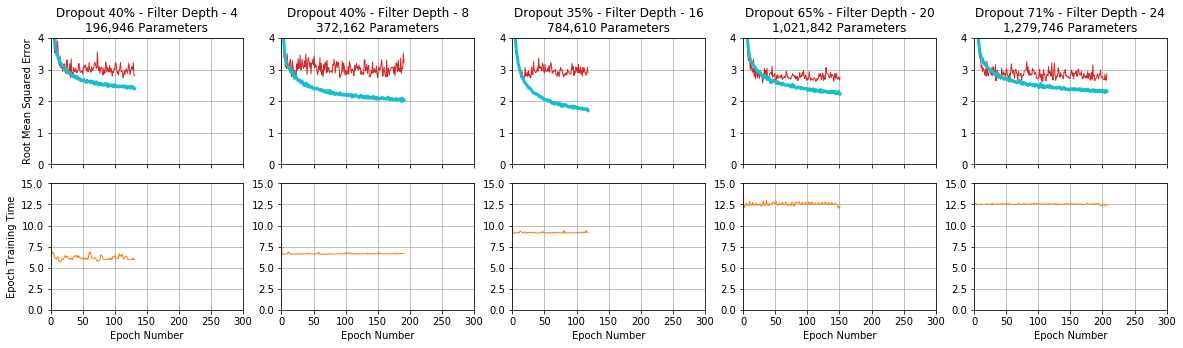

In [89]:
# Create some labels that we will use for the subplots
labels = ['Dropout 40% - Filter Depth - 4\n196,946 Parameters',
          'Dropout 40% - Filter Depth - 8\n372,162 Parameters',
          'Dropout 35% - Filter Depth - 16\n784,610 Parameters',
          'Dropout 65% - Filter Depth - 20\n1,021,842 Parameters',
          'Dropout 71% - Filter Depth - 24\n1,279,746 Parameters']

# Create the subplots
fig, axes = plt.subplots(2, len(groups), figsize=(20,5), sharex=True)
axes = axes.flatten()
# Loop over the groups and plot each on its own subplot
for g, (name, group) in enumerate(groups):
  # Plot Accuracies
  axes[g].plot(group.epoch, group.val_RMSE, c='tab:red',linewidth=1)
  axes[g].plot(group.epoch, group.RMSE, c='tab:cyan',linewidth=3)
  axes[g].grid(True)
  axes[g].set_ylim((0,4))
  axes[g].set_xlim((0,300))
  axes[g].set_title(labels[g])
  # Plot epoch training times
  axes[g+len(groups)].plot(group.epoch, group.times, c='tab:orange',linewidth=1)
  axes[g+len(groups)].grid(True)
  axes[g+len(groups)].set_ylim((0,15))
  axes[g+len(groups)].set_xlim((0,300))
  axes[g+len(groups)].set_xlabel("Epoch Number")
  if (g==0):
    axes[g].set_ylabel("Root Mean Squared Error")
    axes[g+len(groups)].set_ylabel("Epoch Training Time")
    
fig.subplots_adjust(wspace=0.20,hspace=0.15)

### Barchart of Specialist Model Errors

Create a bar chart that shows error for each specialist model.

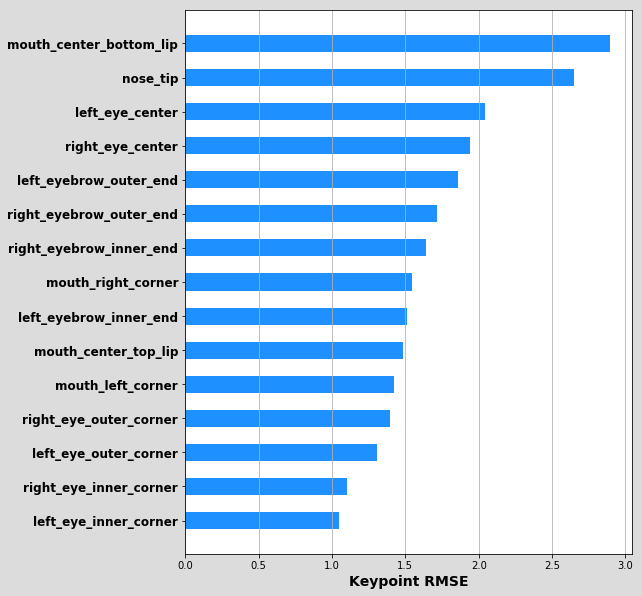

In [117]:
# Read in the original specialist model output
spec_df = pd.read_pickle(drive_path+"OutputData/spec_01.pkl")

# Grab the accuracies for each keypoint
keypoint_mins = spec_df.groupby(['keypoint']).val_RMSE.min().sort_values(ascending=True)

# Set some plot features
bar_width = 0.50
index = np.arange(len(keypoint_mins))

# Create the plot
fig, ax = plt.subplots(1,1, figsize=(8,10))
fig.patch.set_facecolor('gainsboro')
ax.barh(index, keypoint_mins, bar_width, 
       color='dodgerblue')
ax.set_yticks(index)
ax.set_yticklabels(keypoint_mins.index, fontweight='bold', fontsize=12)
ax.set_xlabel("Keypoint RMSE", fontsize=14, fontweight='bold')
ax.grid(True, axis='x')


### Plot a random assortment of nosetips
This shows the variability in what has been labelled a nose tip.

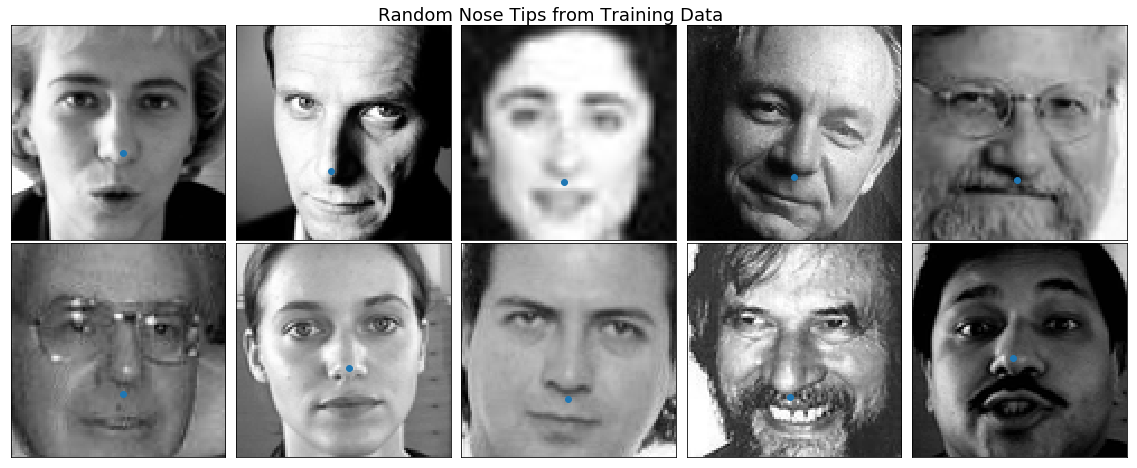

In [28]:
# Get 10 random images
random_images = np.random.randint(0, len(df), 10)

# Create a figure with 10 subplots
fig, axes = plt.subplots(2,5,figsize=(20,8), subplot_kw={'xticks':[],'yticks':[]})
axes = axes.flatten()

# Loop over each and plot the image and the nose_tip keypoint
for a, ax in enumerate(axes):
  ax.imshow(df.iloc[random_images[a],-1].reshape(96,96),cmap='gray')
  ax.scatter(x=df.iloc[random_images[a],-11],
             y=df.iloc[random_images[a],-10])
  
fig.subplots_adjust(hspace=0.0,wspace=0.05)
fig.suptitle("Random Nose Tips from Training Data", fontsize=18, y=0.91)
print()

### Convolution Layers

Plots for the outputs of each convolution layer for our nose tip specialist.

In [31]:
nt_model_path = drive_path+"Models/cnn_4l_spec_nose_tip_d0.2_s0.15_sf20_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5"
nt_model = models.load_model(nt_model_path)

W0804 16:07:26.568227 140259710695296 nn_ops.py:4224] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0804 16:07:26.715865 140259710695296 nn_ops.py:4224] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [32]:
nt_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 20)        80        
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 20)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 40)        7200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 40)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 40)        0

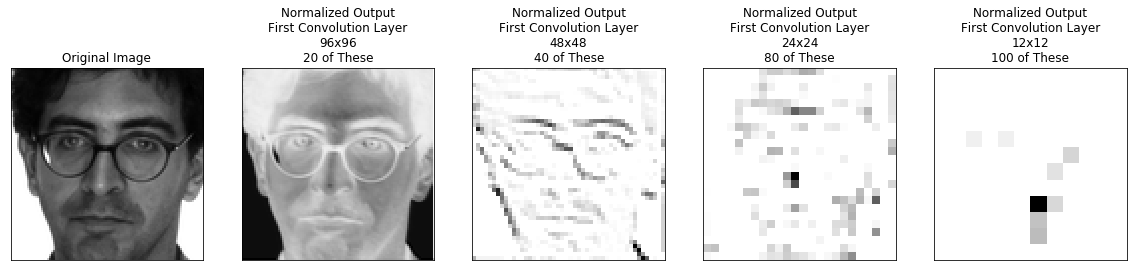

In [90]:
layer_names = ['batch_normalization',
               'batch_normalization_1',
               'batch_normalization_2',
               'batch_normalization_3']

labels = ['Normalized Output\nFirst Convolution Layer\n96x96\n20 of These',
          'Normalized Output\nFirst Convolution Layer\n48x48\n40 of These',
          'Normalized Output\nFirst Convolution Layer\n24x24\n80 of These',
          'Normalized Output\nFirst Convolution Layer\n12x12\n100 of These']

fig, axes = plt.subplots(1, len(layer_names)+1, figsize=(20,8),
                         subplot_kw={'xticks':[],'yticks':[]})

axes = axes.flatten()
axes[0].imshow(df.iloc[0, -1].reshape(96,96),cmap='gray')

for l, layer in enumerate(layer_names):
  intermediate_layer_model = models.Model(inputs=nt_model.input,
                                   outputs=nt_model.get_layer(layer).output)
  intermediate_output = intermediate_layer_model.predict([df.iloc[0, -1].reshape(1,96,96,1)])
  pixels = len(intermediate_output[0,:,:,1])
  plot_data = intermediate_output[0,:,:,1].reshape(pixels,pixels)
  axes[l+1].imshow(plot_data,cmap='gray_r')
  axes[l+1].set_title(labels[l])
axes[0].set_title("Original Image")
  
print()

In [54]:
nt_model.inputs

[<tf.Tensor 'conv2d_input:0' shape=(?, 96, 96, 1) dtype=float32>]